# 📌 랜덤 포레스트

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. 랜덤 포레스트 학습 예제 - 사용자 행동 인식 데이터셋

#### 1.1 데이터 불러오기

In [23]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [24]:
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
new_feature_name_df = get_new_feature_name_df(feature_name_df)

# DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

In [29]:
X_train = pd.read_csv('./human_activity/X_train.txt',sep='\s+', names=feature_name )
X_test = pd.read_csv('./human_activity/X_test.txt',sep='\s+', names=feature_name)

y_train = pd.read_csv('./human_activity/y_train.txt',sep='\s+',header=None,names=['action'])
y_test = pd.read_csv('./human_activity/y_test.txt',sep='\s+',header=None,names=['action'])

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7352, 561) (2947, 561) (7352, 1) (2947, 1)


In [33]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [31]:
y_train = y_train.reshape(-1, 1)
y_test = y_train.reshape(-1,1)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [34]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7352, 561) (2947, 561) (7352,) (2947,)


#### 1.2 랜덤 포레스트 학습, 예측, 평가

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 랜덤 포레스트 학습
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)

# 랜덤 포레스트 예측
y_pred = rf_clf.predict(X_test)

# 랜덤 포레스트 평가
accuracy = accuracy_score(y_test, y_pred)
print("랜덤 포레스트 정확도 : {0:.4f}".format(accuracy))


랜덤 포레스트 정확도 : 0.9196


#### 1.3 랜덤 포레스트 하이퍼 파라미터 튜닝

In [38]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth" : [8, 16, 24],
    "min_samples_leaf" : [1, 6, 12],
    "min_samples_split" : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100,
                                random_state=0,
                                n_jobs=-1)

grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print("최적 하이퍼 파라미터: \n", grid_cv.best_params_)
print("--- " * 20)
print("최고 예측 정확도: {0:.4f}".format(grid_cv.best_score_))

최적 하이퍼 파라미터: 
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 
최고 예측 정확도: 0.9165


In [39]:
# 최적의 하이퍼 파라미터를 적용한 랜덤 포레스트 예측, 평가
rf_clf1 = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=6,
                                 max_depth=16,
                                 min_samples_split=2,
                                 random_state=0)

rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print("예측 정확도: {0:.4f}".format(accuracy_score(y_test, y_pred)))

예측 정확도: 0.9260


#### 1.4 특성 중요도 시각화

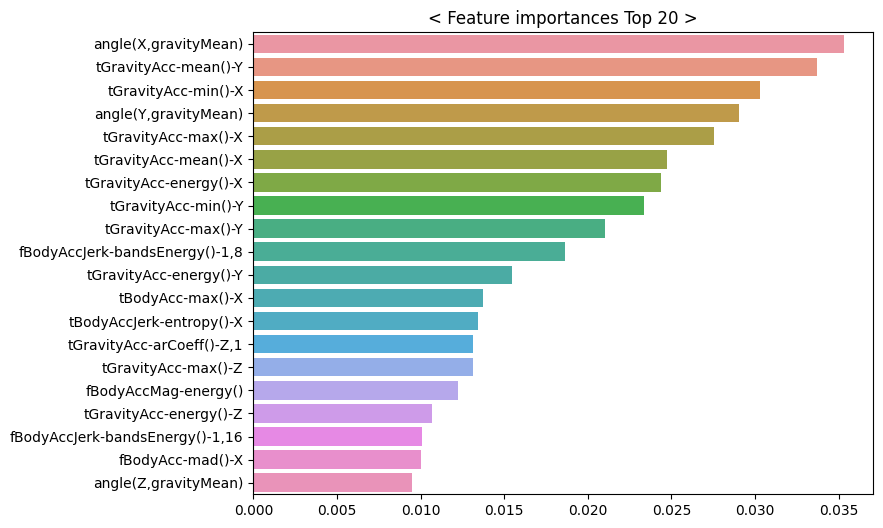

In [40]:
importance_values = rf_clf1.feature_importances_
importances = pd.Series(importance_values, index=X_train.columns)
top_20 = importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title("< Feature importances Top 20 >")
sns.barplot(x=top_20, y=top_20.index)
plt.show()